In [19]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings('ignore')
import re
from wordcloud import WordCloud
from collections import Counter
plt.style.use('default')
sns.set_palette("husl")



In [20]:
with open("/content/intent.json", "r") as file:
    drug_data = json.load(file)
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text
def run_eda(texts, intents):
    df = pd.DataFrame({"text": texts, "intent": intents})

    print("\n🔎 Dataset Shape:", df.shape)
    print("\n📊 Class Distribution:\n", df["intent"].value_counts())

    plt.figure(figsize=(7,5))
    sns.countplot(x="intent", data=df, order=df["intent"].value_counts().index, palette="Set2")
    plt.title("Class Distribution of Intents")
    plt.show()

    for intent in df["intent"].unique():
        wc = WordCloud(width=600, height=400, background_color="white").generate(" ".join(df[df["intent"]==intent]["text"]))
        plt.figure(figsize=(6,4))
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"WordCloud: {intent}")
        plt.show()



In [21]:
class TraditionalMLModels:
    def __init__(self):
        self.models = {
            'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
            'SVM': SVC(kernel='linear', random_state=42, probability=True),
            'Naive Bayes': MultinomialNB(),
            'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
            'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=3),
            'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
        }
        self.vectorizers = {
            'TF-IDF': TfidfVectorizer(max_features=1000, ngram_range=(1, 2), stop_words='english'),
            'Count Vectorizer': CountVectorizer(max_features=1000, ngram_range=(1, 2), stop_words='english')
        }
        self.results = {}

    def prepare_data(self, texts, intents):
        self.label_encoder = LabelEncoder()
        y_encoded = self.label_encoder.fit_transform(intents)
        return texts, y_encoded


    def train_models(self, X_train, X_val, y_train, y_val):
        for vec_name, vectorizer in self.vectorizers.items():
            print(f"\n=== Using {vec_name} ===")
            vec_results = {}


            X_train_vec = vectorizer.fit_transform(X_train)
            X_val_vec = vectorizer.transform(X_val)

            for model_name, model in self.models.items():
                print(f"Training {model_name}...")

                try:

                    model.fit(X_train_vec, y_train)


                    y_pred = model.predict(X_val_vec)
                    y_pred_proba = model.predict_proba(X_val_vec) if hasattr(model, "predict_proba") else None

                    accuracy = accuracy_score(y_val, y_pred)
                    cv_scores = cross_val_score(model, X_train_vec, y_train, cv=3)

                    vec_results[model_name] = {
                        'model': model,
                        'vectorizer': vectorizer,
                        'accuracy': accuracy,
                        'cv_mean': cv_scores.mean(),
                        'cv_std': cv_scores.std(),
                        'predictions': y_pred,
                        'probabilities': y_pred_proba,
                        'true_labels': y_val
                    }

                    print(f"  Accuracy: {accuracy:.4f}, CV Score: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

                except Exception as e:
                    print(f"  Error training {model_name}: {e}")
                    continue

            self.results[vec_name] = vec_results

    def plot_comparison(self):
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Model Comparison Results', fontsize=16, fontweight='bold')


        accuracies = {}
        for vec_name, vec_results in self.results.items():
            accuracies[vec_name] = {model: results['accuracy'] for model, results in vec_results.items()}

        df_acc = pd.DataFrame(accuracies)
        df_acc.plot(kind='bar', ax=axes[0,0])
        axes[0,0].set_title('Accuracy by Model and Vectorizer')
        axes[0,0].set_ylabel('Accuracy')
        axes[0,0].tick_params(axis='x', rotation=45)
        axes[0,0].legend(title='Vectorizer')


        cv_scores = {}
        for vec_name, vec_results in self.results.items():
            cv_scores[vec_name] = {model: results['cv_mean'] for model, results in vec_results.items()}

        df_cv = pd.DataFrame(cv_scores)
        df_cv.plot(kind='bar', ax=axes[0,1])
        axes[0,1].set_title('Cross-Validation Scores')
        axes[0,1].set_ylabel('CV Score')
        axes[0,1].tick_params(axis='x', rotation=45)
        axes[0,1].legend(title='Vectorizer')


        best_vec, best_model = None, None
        best_acc = 0
        for vec_name, vec_results in self.results.items():
            for model_name, results in vec_results.items():
                if results['accuracy'] > best_acc:
                    best_acc = results['accuracy']
                    best_vec, best_model = vec_name, model_name

        if best_vec and best_model:
            best_result = self.results[best_vec][best_model]
            cm = confusion_matrix(best_result['true_labels'], best_result['predictions'])
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                       xticklabels=self.label_encoder.classes_,
                       yticklabels=self.label_encoder.classes_, ax=axes[1,0])
            axes[1,0].set_title(f'Confusion Matrix - {best_model} ({best_vec})\nAccuracy: {best_acc:.4f}')
            axes[1,0].set_xlabel('Predicted')
            axes[1,0].set_ylabel('True')


        all_accuracies = []
        model_names = []
        for vec_name, vec_results in self.results.items():
            for model_name, results in vec_results.items():
                all_accuracies.append(results['accuracy'])
                model_names.append(f"{model_name}\n({vec_name})")

        axes[1,1].barh(range(len(all_accuracies)), all_accuracies)
        axes[1,1].set_yticks(range(len(model_names)))
        axes[1,1].set_yticklabels(model_names)
        axes[1,1].set_title('All Model Accuracies')
        axes[1,1].set_xlabel('Accuracy')
        axes[1,1].set_xlim(0, 1)

        plt.tight_layout()
        plt.show()

        return best_vec, best_model



In [22]:
class CustomBERTClassifier(nn.Module):
    def __init__(self, num_labels, model_name='bert-base-uncased'):
        super(CustomBERTClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        return self.classifier(pooled_output)

class IntentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }



In [23]:
class BERTIntentClassifier:
    def __init__(self):
        self.model = None
        self.tokenizer = None
        self.label_encoder = None
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def train(self, X_train, X_val, y_train, y_val, output_dir="bert_model", epochs=5):

        model_name = "bert-base-uncased"
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        num_labels = len(np.unique(y_train))


        self.model = CustomBERTClassifier(num_labels=num_labels, model_name=model_name)
        self.model.to(self.device)


        train_dataset = IntentDataset(X_train, y_train, self.tokenizer)
        val_dataset = IntentDataset(X_val, y_val, self.tokenizer)


        train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)


        optimizer = AdamW(self.model.parameters(), lr=2e-5)

        criterion = nn.CrossEntropyLoss()

        print("Training BERT model...")
        best_accuracy = 0

        for epoch in range(epochs):
            self.model.train()
            total_loss = 0

            for batch in train_loader:
                optimizer.zero_grad()

                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)

                outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

            self.model.eval()
            correct = 0
            total = 0

            with torch.no_grad():
                for batch in val_loader:
                    input_ids = batch['input_ids'].to(self.device)
                    attention_mask = batch['attention_mask'].to(self.device)
                    labels = batch['labels'].to(self.device)

                    outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
                    predictions = torch.argmax(outputs, dim=1)
                    correct += (predictions == labels).sum().item()
                    total += labels.size(0)

            accuracy = correct / total
            avg_loss = total_loss / len(train_loader)

            print(f'Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f} - Accuracy: {accuracy:.4f}')

            if accuracy > best_accuracy:
                best_accuracy = accuracy

                os.makedirs(output_dir, exist_ok=True)
                torch.save(self.model.state_dict(), f'{output_dir}/best_model.pt')

        print(f"Best BERT Validation Accuracy: {best_accuracy:.4f}")
        return best_accuracy

    def predict(self, texts):
        self.model.eval()
        predictions = []
        confidences = []

        for text in texts:
            encoding = self.tokenizer(
                text,
                truncation=True,
                padding='max_length',
                max_length=128,
                return_tensors='pt'
            )

            input_ids = encoding['input_ids'].to(self.device)
            attention_mask = encoding['attention_mask'].to(self.device)

            with torch.no_grad():
                outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
                probs = torch.nn.functional.softmax(outputs, dim=-1)
                pred = torch.argmax(probs, dim=1).item()
                confidence = probs[0][pred].item()

            predictions.append(pred)
            confidences.append(confidence)

        return predictions, confidences


In [24]:
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score

def analyze_models(traditional_ml, best_vec, best_model, bert_classifier,
                   X_val, y_val_encoded, label_encoder,
                   traditional_probs, bert_confs):


    classes = label_encoder.classes_

    y_val_pred_ml = traditional_ml.results[best_vec][best_model]['predictions']
    y_val_pred_bert, _ = bert_classifier.predict(X_val)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle("Confusion Matrices: Best Traditional vs BERT", fontsize=16, fontweight="bold")

    cm_ml = confusion_matrix(y_val_encoded, y_val_pred_ml)
    sns.heatmap(cm_ml, annot=True, fmt="d", cmap="Blues",
                xticklabels=classes, yticklabels=classes, ax=axes[0])
    axes[0].set_title(f"Traditional: {best_model}")

    cm_bert = confusion_matrix(y_val_encoded, y_val_pred_bert)
    sns.heatmap(cm_bert, annot=True, fmt="d", cmap="Greens",
                xticklabels=classes, yticklabels=classes, ax=axes[1])
    axes[1].set_title("BERT")

    plt.tight_layout()
    plt.show()

    def plot_classification_heatmap(y_true, y_pred, model_name):
        report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)
        df = pd.DataFrame(report).transpose()

        plt.figure(figsize=(8, 6))
        sns.heatmap(df.iloc[:-1, :-1], annot=True, cmap="YlGnBu", cbar=False, fmt=".2f")
        plt.title(f"Classification Report - {model_name}", fontsize=14, fontweight="bold")
        plt.ylabel("Classes")
        plt.xlabel("Metrics")
        plt.show()

    plot_classification_heatmap(y_val_encoded, y_val_pred_ml, f"Traditional: {best_model}")
    plot_classification_heatmap(y_val_encoded, y_val_pred_bert, "BERT")

    plt.figure(figsize=(10, 6))
    sns.kdeplot(traditional_probs, shade=True, label=f"Traditional: {best_model}", color="blue")
    sns.kdeplot(bert_confs, shade=True, label="BERT", color="green")
    plt.title("Confidence Distribution", fontsize=14, fontweight="bold")
    plt.xlabel("Confidence Score")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

    metrics_summary = {
        "Model": ["Traditional", "BERT"],
        "Accuracy": [
            (y_val_pred_ml == y_val_encoded).mean(),
            (y_val_pred_bert == y_val_encoded).mean()
        ],
        "Precision (weighted)": [
            precision_score(y_val_encoded, y_val_pred_ml, average="weighted"),
            precision_score(y_val_encoded, y_val_pred_bert, average="weighted")
        ],
        "Recall (weighted)": [
            recall_score(y_val_encoded, y_val_pred_ml, average="weighted"),
            recall_score(y_val_encoded, y_val_pred_bert, average="weighted")
        ],
        "F1 (weighted)": [
            f1_score(y_val_encoded, y_val_pred_ml, average="weighted"),
            f1_score(y_val_encoded, y_val_pred_bert, average="weighted")
        ],
    }

    df_metrics = pd.DataFrame(metrics_summary)
    print("\n" + "="*60)
    print("OVERALL METRICS COMPARISON")
    print("="*60)
    print(df_metrics.to_string(index=False))




🔎 Dataset Shape: (902, 2)

📊 Class Distribution:
 intent
drug_medical    783
irrelevant       74
greeting         45
Name: count, dtype: int64


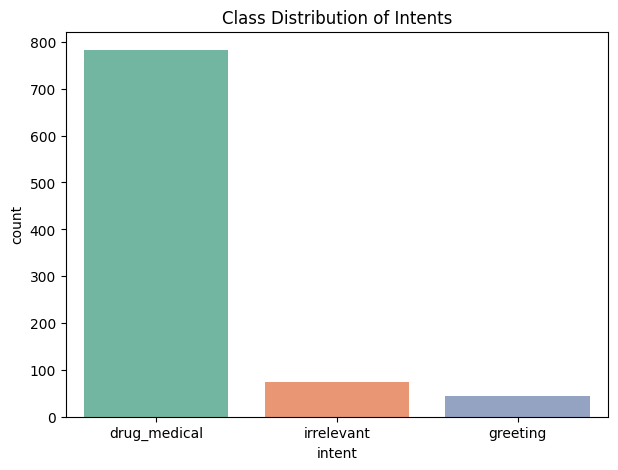

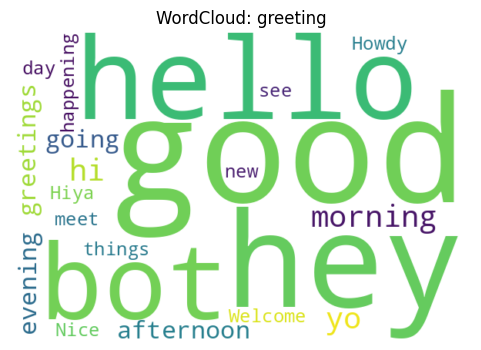

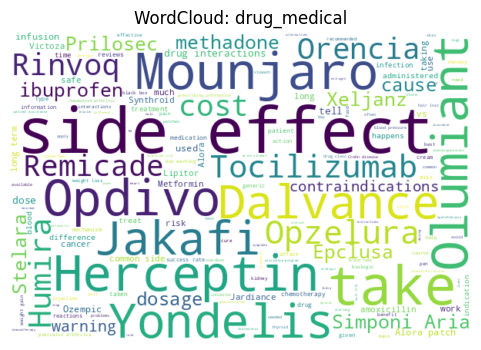

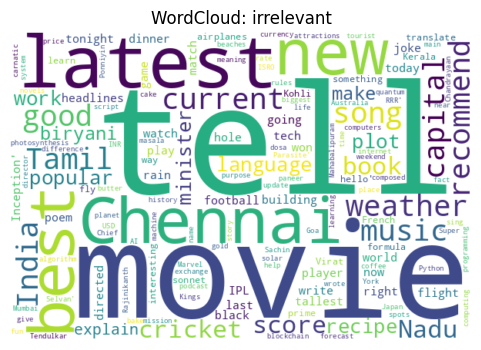

Dataset Overview:
Total samples: 902
Training samples: 631
Validation samples: 271
Classes: {'greeting', 'drug_medical', 'irrelevant'}
Class distribution: {'drug_medical': 783, 'irrelevant': 74, 'greeting': 45}

TRAINING TRADITIONAL ML MODELS

=== Using TF-IDF ===
Training Logistic Regression...
  Accuracy: 0.8856, CV Score: 0.8685 (±0.0021)
Training SVM...
  Accuracy: 0.9114, CV Score: 0.9128 (±0.0020)
Training Naive Bayes...
  Accuracy: 0.8708, CV Score: 0.8685 (±0.0021)
Training Random Forest...
  Accuracy: 0.9668, CV Score: 0.9525 (±0.0140)
Training K-Nearest Neighbors...
  Accuracy: 0.6125, CV Score: 0.4561 (±0.1260)
Training XGBoost...
  Accuracy: 0.9114, CV Score: 0.9002 (±0.0041)

=== Using Count Vectorizer ===
Training Logistic Regression...
  Accuracy: 0.9041, CV Score: 0.9002 (±0.0066)
Training SVM...
  Accuracy: 0.9299, CV Score: 0.9287 (±0.0102)
Training Naive Bayes...
  Accuracy: 0.9004, CV Score: 0.9208 (±0.0155)
Training Random Forest...
  Accuracy: 0.9668, CV Score: 0.

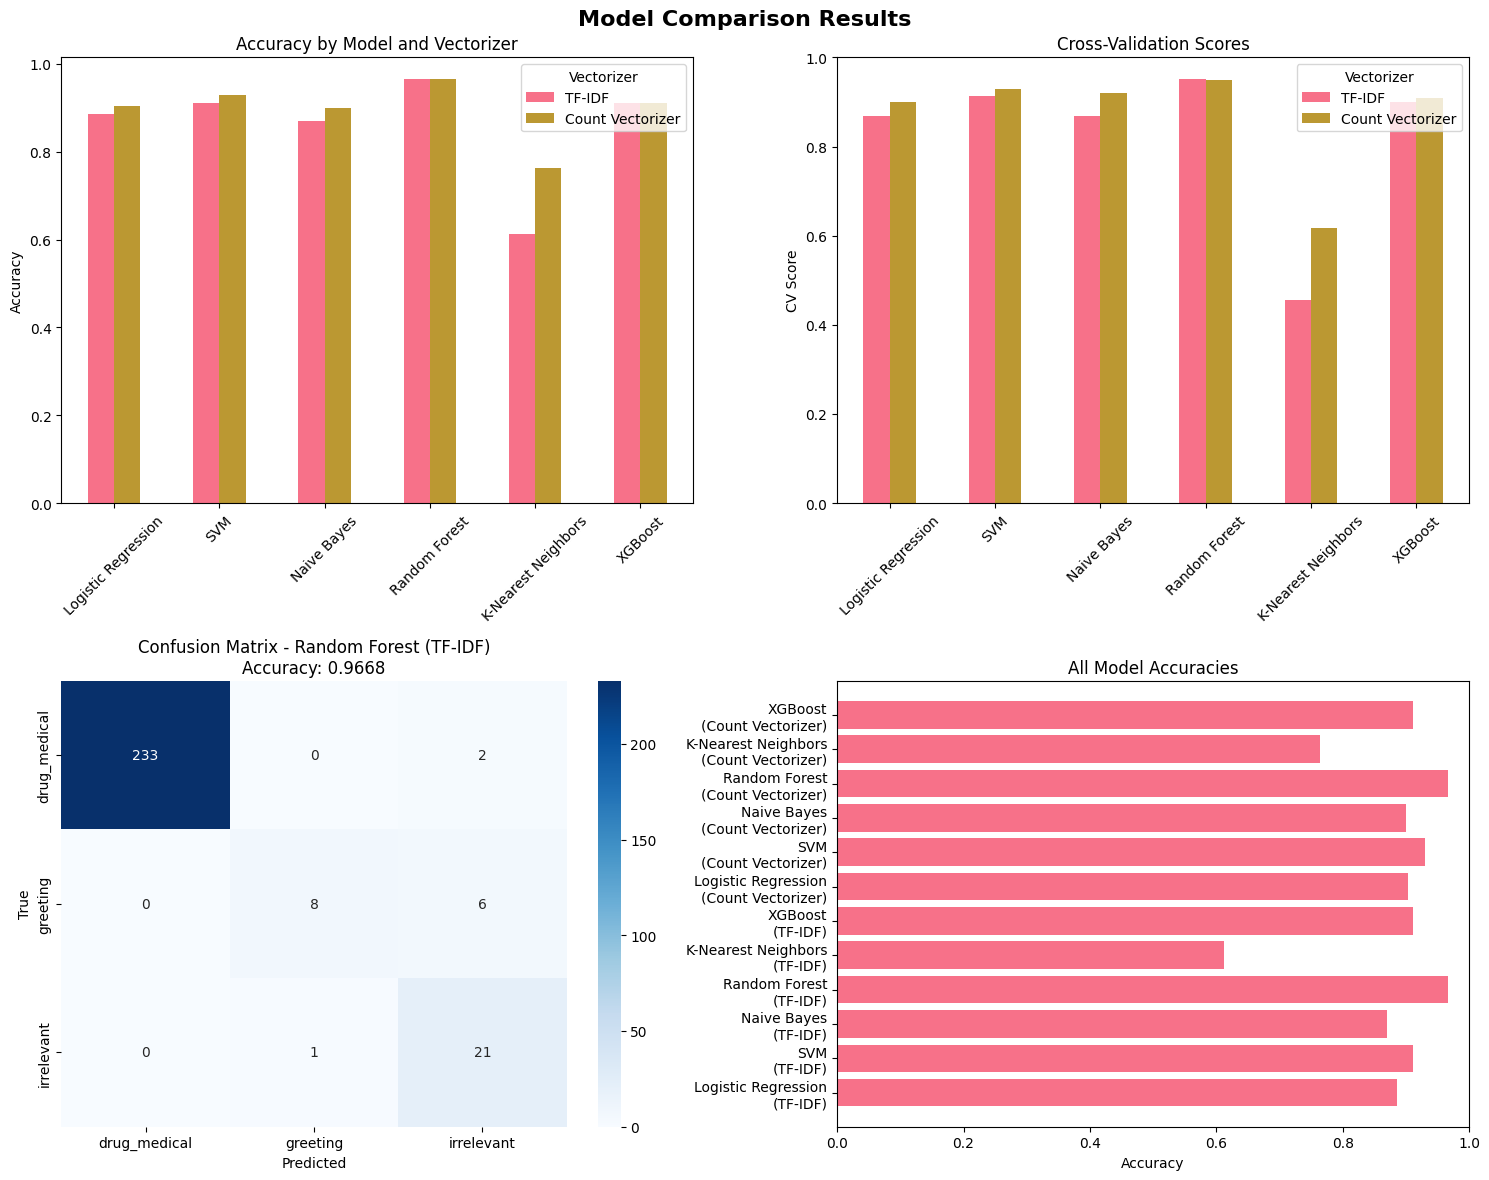


TRAINING BERT MODEL
Training BERT model...
Epoch 1/8 - Loss: 0.2522 - Accuracy: 0.9889
Epoch 2/8 - Loss: 0.0318 - Accuracy: 0.9963
Epoch 3/8 - Loss: 0.0065 - Accuracy: 0.9926
Epoch 4/8 - Loss: 0.0022 - Accuracy: 0.9926
Epoch 5/8 - Loss: 0.0014 - Accuracy: 0.9926
Epoch 6/8 - Loss: 0.0010 - Accuracy: 0.9926
Epoch 7/8 - Loss: 0.0008 - Accuracy: 0.9926
Epoch 8/8 - Loss: 0.0006 - Accuracy: 0.9926
Best BERT Validation Accuracy: 0.9963

FINAL COMPARISON


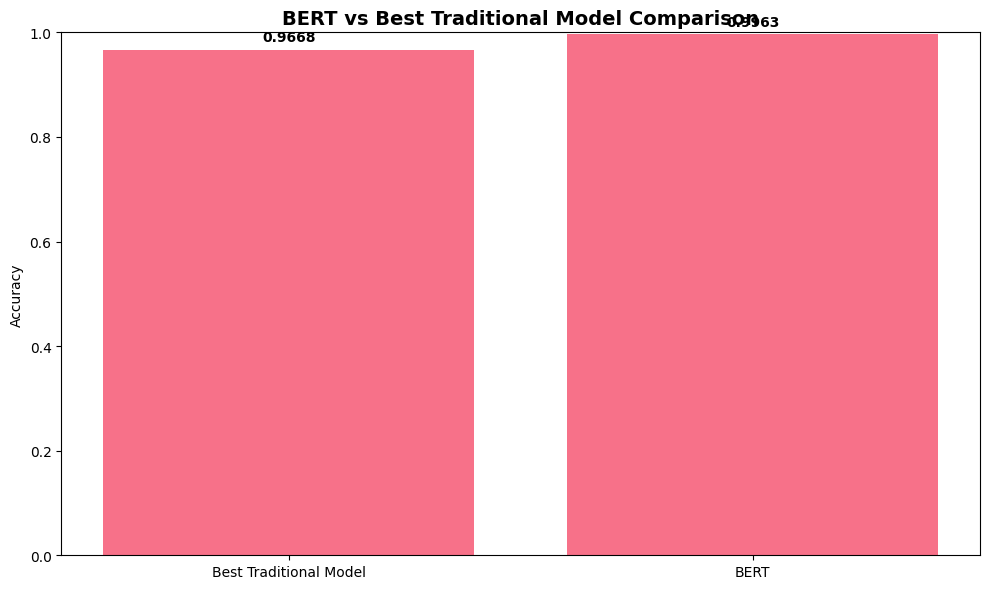


Best Traditional Model: Random Forest with TF-IDF
Traditional Model Accuracy: 0.9668
BERT Accuracy: 0.9963
BERT outperforms traditional model by 3.05%

SAMPLE PREDICTIONS

Test Predictions Comparison:
----------------------------------------------------------------------------------------------------
Text                      Traditional     Confidence BERT            Confidence
----------------------------------------------------------------------------------------------------
hello there!              greeting        0.995      greeting        0.999     
what are the side effects of humira? irrelevant      0.475      drug_medical    1.000     
tell me something funny   irrelevant      0.731      irrelevant      0.997     
how does aspirin work?    drug_medical    0.760      drug_medical    1.000     
good evening              greeting        0.592      greeting        0.999     
medicine for pain         irrelevant      0.429      drug_medical    0.999     
what's your name?        

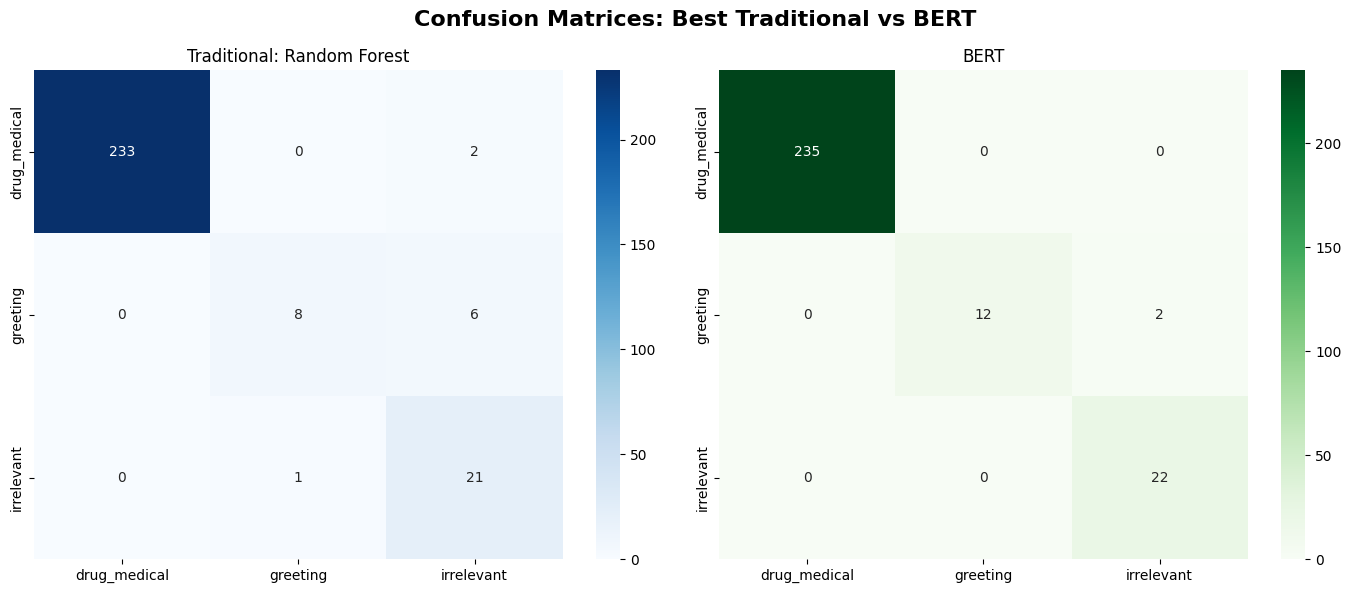

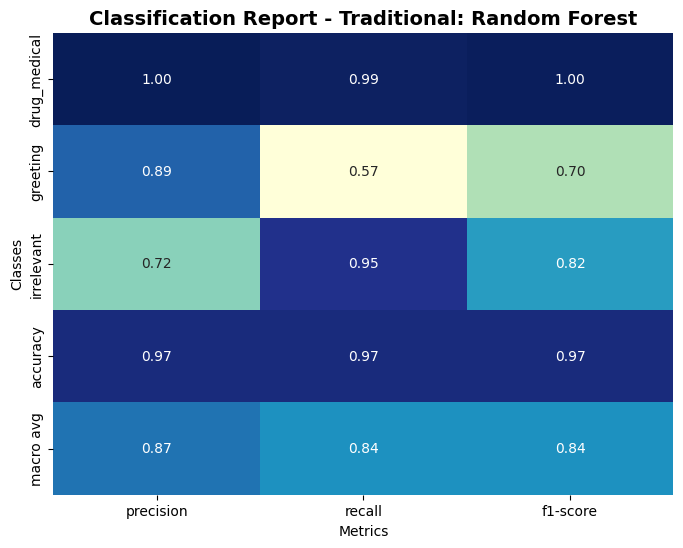

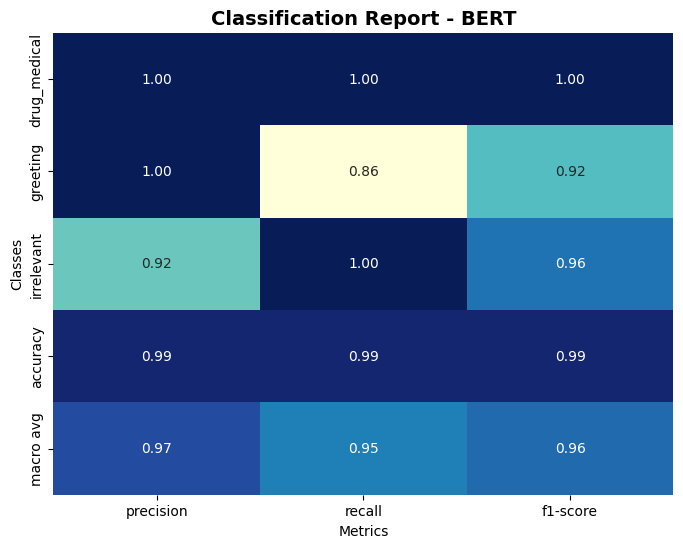

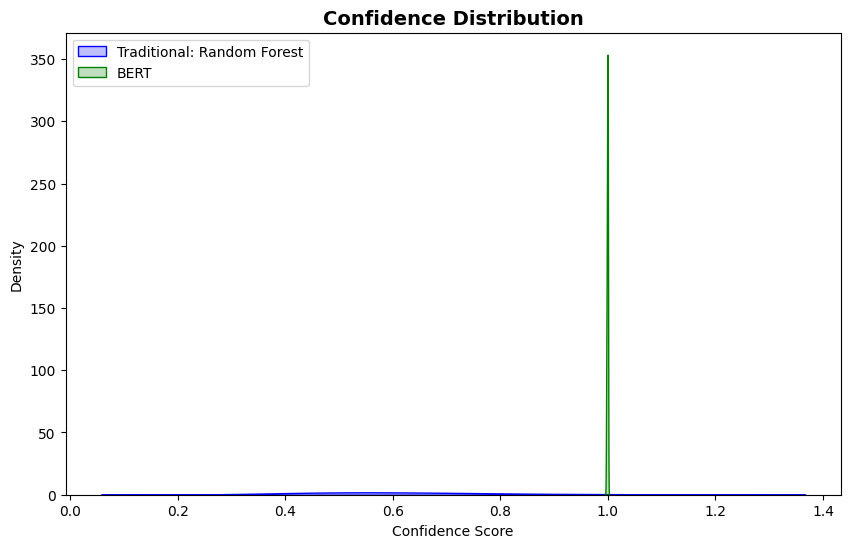


OVERALL METRICS COMPARISON
      Model  Accuracy  Precision (weighted)  Recall (weighted)  F1 (weighted)
Traditional   0.96679              0.971865            0.96679       0.966245
       BERT   0.99262              0.993235            0.99262       0.992497


In [26]:
def main():
    data = drug_data
    texts = [item['text'] for item in data]
    intents = [item['intent'] for item in data]
    run_eda(texts, intents)
    X_train, X_val, y_train, y_val = train_test_split(
        texts, intents, test_size=0.3, random_state=42, stratify=intents
    )

    print("Dataset Overview:")
    print(f"Total samples: {len(texts)}")
    print(f"Training samples: {len(X_train)}")
    print(f"Validation samples: {len(X_val)}")
    print(f"Classes: {set(intents)}")
    print(f"Class distribution: {pd.Series(intents).value_counts().to_dict()}")

    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_val_encoded = label_encoder.transform(y_val)

    print("\n" + "="*60)
    print("TRAINING TRADITIONAL ML MODELS")
    print("="*60)

    traditional_ml = TraditionalMLModels()
    traditional_ml.label_encoder = label_encoder
    traditional_ml.train_models(X_train, X_val, y_train_encoded, y_val_encoded)
    best_vec, best_model = traditional_ml.plot_comparison()

    print("\n" + "="*60)
    print("TRAINING BERT MODEL")
    print("="*60)

    bert_classifier = BERTIntentClassifier()
    bert_accuracy = bert_classifier.train(X_train, X_val, y_train_encoded, y_val_encoded, epochs=8)
    bert_classifier.label_encoder = label_encoder

    print("\n" + "="*60)
    print("FINAL COMPARISON")
    print("="*60)

    best_traditional_acc = traditional_ml.results[best_vec][best_model]['accuracy']

    models_comparison = {
        'Best Traditional Model': best_traditional_acc,
        'BERT': bert_accuracy
    }

    plt.figure(figsize=(10, 6))
    bars = plt.bar(models_comparison.keys(), models_comparison.values())
    plt.title('BERT vs Best Traditional Model Comparison', fontsize=14, fontweight='bold')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)

    for bar, value in zip(bars, models_comparison.values()):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.4f}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

    print(f"\nBest Traditional Model: {best_model} with {best_vec}")
    print(f"Traditional Model Accuracy: {best_traditional_acc:.4f}")
    print(f"BERT Accuracy: {bert_accuracy:.4f}")

    if bert_accuracy > best_traditional_acc:
        improvement = ((bert_accuracy - best_traditional_acc) / best_traditional_acc) * 100
        print(f"BERT outperforms traditional model by {improvement:.2f}%")
    else:
        improvement = ((best_traditional_acc - bert_accuracy) / bert_accuracy) * 100
        print(f"Traditional model outperforms BERT by {improvement:.2f}%")

    print("\n" + "="*60)
    print("SAMPLE PREDICTIONS")
    print("="*60)

    test_texts = [
        "hello there!",
        "what are the side effects of humira?",
        "tell me something funny",
        "how does aspirin work?",
        "good evening",
        "medicine for pain",
        "what's your name?",
        "dose of vitamin d"
    ]

    best_traditional = traditional_ml.results[best_vec][best_model]['model']
    vectorizer = traditional_ml.results[best_vec][best_model]['vectorizer']

    test_vec = vectorizer.transform(test_texts)
    traditional_preds = best_traditional.predict(test_vec)
    traditional_labels = label_encoder.inverse_transform(traditional_preds)

    traditional_probs = []
    if hasattr(best_traditional, "predict_proba"):
        probas = best_traditional.predict_proba(test_vec)
        traditional_probs = [max(proba) for proba in probas]
    else:
        traditional_probs = [1.0] * len(test_texts)

    bert_preds, bert_confs = bert_classifier.predict(test_texts)
    bert_labels = label_encoder.inverse_transform(bert_preds)

    print("\nTest Predictions Comparison:")
    print("-" * 100)
    print(f"{'Text':<25} {'Traditional':<15} {'Confidence':<10} {'BERT':<15} {'Confidence':<10}")
    print("-" * 100)

    for i, text in enumerate(test_texts):
        print(f"{text:<25} {traditional_labels[i]:<15} {traditional_probs[i]:<10.3f} "
              f"{bert_labels[i]:<15} {bert_confs[i]:<10.3f}")
    analyze_models(
        traditional_ml=traditional_ml,
        best_vec=best_vec,
        best_model=best_model,
        bert_classifier=bert_classifier,
        X_val=X_val,
        y_val_encoded=y_val_encoded,
        label_encoder=label_encoder,
        traditional_probs=traditional_probs,
        bert_confs=bert_confs
    )

if __name__ == "__main__":
    main()